# **Environmental SetUp ⚙️**

The section loads **essential modules** for seamless **notebook functioning**, encompassing libraries **like NumPy, Pandas, and TensorFlow**. Additionally, it establishes **key environmental constants**, such as **image dimensions and learning rates**, vital for **subsequent analysis** and **model training**.

In [ ]:
# General
import os
import keras
import numpy as np
import pandas as pd
import tensorflow as tf

# Data
import plotly.express as px
import matplotlib.pyplot as plt

# Data Preprocessing
import tensorflow.data as tfds
from sklearn.model_selection import train_test_split

# Model
from keras.applications import VGG16
from keras.applications import Xception, InceptionV3
from keras.applications import ResNet50V2, ResNet152V2
from keras.applications import MobileNetV3Small, MobileNetV3Large

# Model training
from keras import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten, GlobalAveragePooling2D
from keras.layers import InputLayer

# Model Callbacks
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint

In [ ]:
# Setting constants for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Constants
BATCH_SIZE = 32
IMAGE_SIZE = 224

# **Loading & Processing UTK Face 🧔‍♂️**

The **UTKFace dataset**, found on **Kaggle**, is a comprehensive collection of **facial images specifically** curated for **age and gender recognition tasks**. It comprises over **20,000 images of human faces** with annotations for **age, gender, and ethnicity**. These images are **diverse**, representing **various races, ages, and genders,** making it an extensive and valuable resource for **machine learning and computer vision research.**

* Each image in the **UTKFace dataset** is labeled with the **person's age**, ranging from **0 to 116 years old**, and their **gender**, **classified as male or female**.

* Additionally, the dataset includes information about the **person's ethnicity**, allowing for **more nuanced analyses and applications.**

Researchers and developers often utilize this dataset to train and test algorithms for **age estimation, gender classification**, and other related tasks in **facial recognition technology**. Its **large size** and **diverse representation** of **facial features** make it a popular choice for exploring and developing models in the field of computer vision.

Total number of images  : 23708
Sample Image path       : 9_1_0_20170105000600802.jpg.chip.jpg
Sample Age              : 9
Sample Gender           : Female



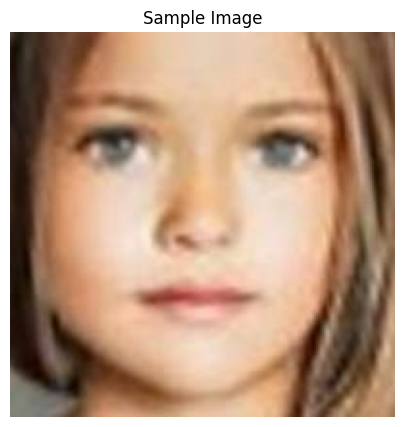

In [ ]:
# Initialize the directory path
dir_path = "/kaggle/input/utkface-new/UTKFace/"
image_paths = os.listdir(dir_path)

# Initialize a Gender Mapping
gender_mapping = ["Male", "Female"]

# Choose and load an image randomly
rand_image_path = np.random.choice(image_paths)
rand_image = plt.imread(dir_path + rand_image_path)/255.
sample_age, sample_gender, *_ = rand_image_path.split("_")

print(f"Total number of images  : {len(image_paths)}")
print(f"Sample Image path       : {rand_image_path}")
print(f"Sample Age              : {sample_age}")
print(f"Sample Gender           : {gender_mapping[int(sample_gender)]}\n")

# Show the image
plt.figure(figsize = (5,5))
plt.title("Sample Image")
plt.imshow(rand_image)
plt.axis("off")
plt.show()

Handling **23,708 images** necessitates **memory-efficient strategies** like **batching or utilizing image generators** to **avoid overwhelming memory constraints**. Moreover, the structure of the image path, **delineating age and gender**—where the **first part signifies age** and the **second denotes gender** (**0 for male**, **1 for female**)—provides **crucial information** for subsequent **analysis and categorization**.

Careful management of these paths will facilitate targeted data processing based on **age and gender attributes.**

In [ ]:
# Initialize a male counter variable
male_count = 0

# Initialize variable to store all the ages.
ages = []

# Loop over the paths and check for male images.
for path in image_paths:
    path_split = path.split("_")
    if "0" == path_split[1]:
        male_count += 1
    ages.append(int(path_split[0]))

# Computee total female counts
female_count = len(image_paths) - male_count

# Visualizing The Class Imbalance
pie_chart = px.pie(
    names = gender_mapping,
    values = [male_count, female_count],
    hole = 0.4,
    title = "Gender Distribution (Donut Chart)",
    height = 500
)
pie_chart.show()

bar_graph = px.bar(
    y = gender_mapping,
    x = [male_count, female_count],
    title = "Gender Distribution (Bar Graph)",
    color = gender_mapping,
    height = 500
)
bar_graph.update_layout(
    yaxis_title = "Gender",
    xaxis_title = "Frequency Count"
)
bar_graph.show()

It seems our dataset exhibits a **slight class imbalance**, with a **higher count of male images** compared to **female ones**—approximately **52% male and 48% female representation**. While this imbalance isn't **substantial enough** to **significantly impact model accuracy**, it's worth noting for a **comprehensive understanding** of **the dataset's bias towards male images**. Managing this slight skew could enhance the model's robustness and fairness in predictions, even though its current impact on accuracy might be limited.

In [ ]:
# Histogram
fig = px.histogram(sorted(ages), title = "Age Distribution")
fig.update_layout(
    xaxis_title = "Age",
    yaxis_title = "Value Counts"
)
fig.show()

# Violin Plot
fig = px.violin(x = sorted(ages), title = "Age Distribution")
fig.update_layout(
    xaxis_title = "Age",
    yaxis_title = "Distribution"
)
fig.show()

# Box Plot
fig = px.box(x = sorted(ages), notched=True, title = "Age Distribution")
fig.update_layout(
    xaxis_title = "Age",
)
fig.show()

The **histogram analysis** reveals **two prominent peaks** in our **dataset distribution**. The **first cluster encompasses ages** from **0 to approximately 12**, while the second spans around **16 to 45 years**.

Interestingly, these peaks exhibit **distinct intensities**, with the **latter peak notably stronger**. Specifically, we observe a **peak around age 1** with approximately **1123 images**, contrasting the substantial peak at **26 years with approximately 2197 images**.

Notably, while our dataset does include a **few images of elderly individuals aged above 80**, these occurrences constitute minor peaks. Overall, this distribution indicates a **potential bias towards younger age groups**, underscoring the **dataset's emphasis on images depicting individuals in their early years** and **adulthood rather than advanced age.**

The insights gleaned from both the **violin plot** and the **box plot** affirm our **initial observations** derived from the **histogram**. The **data distinctly segregates** into **two subsets**: a **significant portion featuring images of very young children**, corroborating the **histogram's peak around age 1**, and a **substantial concentration of adult individuals between 26 and 45 years old**. The **violin plot** particularly **emphasizes this bimodal distribution.**

Upon **closer examination** of the **box plot**, a **notable squeeze** towards the **left side echoes** what we observed in the **histogram**. This compression stems from the **elongated and relatively sparse distribution** of **values in the older age ranges**. It **reaffirms** our understanding that the **dataset exhibits** a **slight skew towards younger individuals**.

This **inherent bias** may indeed **impact our model's accuracy**, as it tends to **learn and generalize more effectively** from the **abundance of data on younger demographics**, **potentially neglecting patterns or nuances prevalent in older age groups**. Addressing this **skew becomes pivotal** to ensure our **model's fair and comprehensive learning across diverse age categories.**

In [ ]:
# SHuffling the Images
np.random.shuffle(image_paths)

# Split data into training, testing and validation set
train_images, test_images = train_test_split(
    image_paths,
    train_size = 0.9,
    test_size = 0.1
)

train_images, valid_images = train_test_split(
    image_paths,
    train_size = 0.9,
    test_size = 0.1
)

print(f"Training Size : {len(train_images)}")
print(f"Testing Size  : {len(test_images)}")

# Extract age and gender
train_ages = [int(path.split("_")[0]) for path in train_images]
train_genders = [int(path.split("_")[1]) for path in train_images]

valid_ages = [int(path.split("_")[0]) for path in valid_images]
valid_genders = [int(path.split("_")[1]) for path in valid_images]

test_ages = [int(path.split("_")[0]) for path in test_images]
test_genders = [int(path.split("_")[1]) for path in test_images]

Training Size : 21337
Testing Size  : 2371


Because we have a **huge number of images**, it will be better to use **Tensorflow data set** for **efficient processing**.

In [ ]:
def show_image(image, show=False):
    """
    Displays the provided image without axis.

    Args:
    - image (array-like): The image data to be displayed.
    - show (bool): If True, displays the image immediately. Defaults to False.

    Returns:
    - None
    """
    plt.imshow(image)
    plt.axis("off")

    if show:
        plt.show()


def preprocess_age_data(image_path, age, gender, dir_path=dir_path, IMAGE_SIZE = IMAGE_SIZE):
    """
    Preprocesses an image for analysis by extracting age and gender from the image path,
    loading and decoding the image, resizing it to (IMAGE_SIZE,IMAGE_SIZE), normalizing pixel values,
    and returning the preprocessed image along with age and gender labels.

    Args:
    - image_path (str): The path to the image file.
    - dir_path (str): The directory path where the image is located. Defaults to `dir_path`.

    Returns:
    - tuple: A tuple containing the preprocessed image as a TensorFlow tensor,
             the age (int), and the gender (int) extracted from the image path.
    """
    # Load the Image
    image = tf.io.read_file(dir_path + image_path)
    image = tf.io.decode_jpeg(image)

    # Resize and Normalize the Image
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    image = image / 255.
    image = tf.cast(image, tf.float32)

    return image, age

def preprocess_gender_data(image_path, age, gender, dir_path=dir_path, IMAGE_SIZE = IMAGE_SIZE):
    """
    Preprocesses an image for analysis by extracting age and gender from the image path,
    loading and decoding the image, resizing it to (IMAGE_SIZE,IMAGE_SIZE), normalizing pixel values,
    and returning the preprocessed image along with age and gender labels.

    Args:
    - image_path (str): The path to the image file.
    - dir_path (str): The directory path where the image is located. Defaults to `dir_path`.

    Returns:
    - tuple: A tuple containing the preprocessed image as a TensorFlow tensor,
             the age (int), and the gender (int) extracted from the image path.
    """
    # Load the Image
    image = tf.io.read_file(dir_path + image_path)
    image = tf.io.decode_jpeg(image)

    # Resize and Normalize the Image
    image = tf.image.resize(image, (IMAGE_SIZE, IMAGE_SIZE))
    image = image / 255.
    image = tf.cast(image, tf.float32)

    return image, gender

In [ ]:
# Obtain training, testing and validation datasets
train_ds = tfds.Dataset.from_tensor_slices((train_images, train_ages, train_genders)).shuffle(2000)
train_age_ds = train_ds.map(preprocess_age_data, num_parallel_calls=BATCH_SIZE).batch(BATCH_SIZE).prefetch(tfds.AUTOTUNE)
train_gender_ds = train_ds.map(preprocess_gender_data, num_parallel_calls=BATCH_SIZE).batch(BATCH_SIZE).prefetch(tfds.AUTOTUNE)

valid_ds = tfds.Dataset.from_tensor_slices((valid_images, valid_ages, valid_genders)).shuffle(2000)
valid_age_ds = valid_ds.map(preprocess_age_data, num_parallel_calls=BATCH_SIZE).batch(BATCH_SIZE).prefetch(tfds.AUTOTUNE)
valid_gender_ds = valid_ds.map(preprocess_gender_data, num_parallel_calls=BATCH_SIZE).batch(BATCH_SIZE).prefetch(tfds.AUTOTUNE)

test_ds  = tfds.Dataset.from_tensor_slices((test_images, test_ages, test_genders)).shuffle(500)
test_age_ds = test_ds.map(preprocess_age_data, num_parallel_calls=BATCH_SIZE).batch(BATCH_SIZE).prefetch(tfds.AUTOTUNE)
test_gender_ds = test_ds.map(preprocess_gender_data, num_parallel_calls=BATCH_SIZE).batch(BATCH_SIZE).prefetch(tfds.AUTOTUNE)

We have **successfully processed and loaded the images**. It's time to **visualize some of them**.

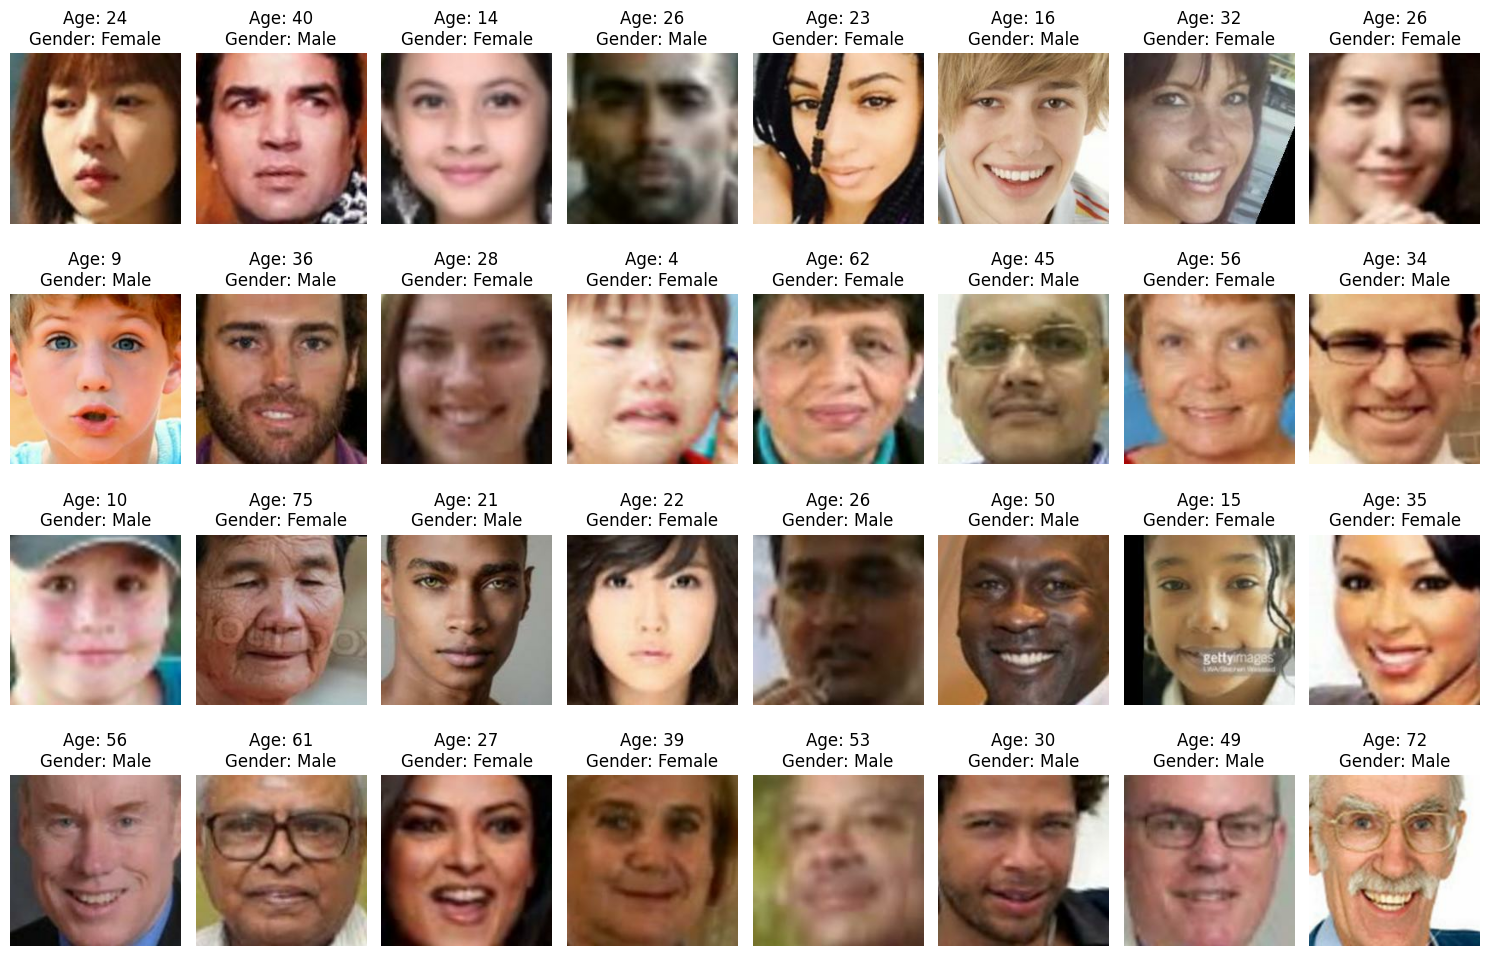

In [ ]:
plt.figure(figsize=(15, 10))
for images, ages, genders in train_ds.batch(BATCH_SIZE).take(1):

    for index in range(len(images)):
        image = tf.io.read_file(dir_path + images[index])
        image = tf.io.decode_jpeg(image)
        plt.subplot(4, 8, index + 1)
        plt.imshow(image)
        plt.title(f"Age: {ages[index]}\nGender: {gender_mapping[genders[index]]}")
        plt.axis("off")

plt.tight_layout()
plt.show()

# **Backbone Comparisions 📊**

As we **aim to establish an optimal backbone** for our **final model**, we're exploring various **candidate models** to serve as the **foundational architecture**. This process involves **evaluating multiple backbones** to gauge their performance comprehensively.

By conducting a **comparative analysis,** we seek to discern the **strengths and weaknesses** of **each backbone model**. Our objective is to identify the **most suitable backbone architecture** that will serve as the **robust foundation** for our **final model**. Subsequently, **fine-tuning will be employed to refine and tailor the selected backbone**, ensuring the development of an **optimized and effective model**.

In [ ]:
# Initializing all the Backbones
backbones = [
    (
        "VGG16",
        VGG16(
            input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3),
            weights = "imagenet",
            include_top = False
        )
    ),
    (
        "ResNet50V2",
        ResNet50V2(
            input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3),
            weights = "imagenet",
            include_top = False
        )
    ),

    (
        "ResNet152V2",
        ResNet152V2(
            input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3),
            weights = "imagenet",
            include_top = False
        )
    ),

    (
        "Xception",
        Xception(
            input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3),
            weights = "imagenet",
            include_top = False
        )
    ),

    (
        "InceptionV3",
        InceptionV3(
            input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3),
            weights = "imagenet",
            include_top = False
        )
    ),

    (
        "MobileNetV3Small",
        MobileNetV3Small(
            input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3),
            weights = "imagenet",
            include_top = False
        )
    ),

    (
        "MobileNetV3Large",
        MobileNetV3Large(
            input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3),
            weights = "imagenet",
            include_top = False
        )
    ),
]

In order to find the best backbone, we need to first train a quite small network for few iterations and then we will see which backbone will lead to a robust performance faster and better.

---
$NOTE$

After conducting several experiments, it has become evident that building a single model for both age and gender predictions is not yielding optimal results. Despite achieving remarkable performance in predicting age, the accuracy for gender prediction is suboptimal. Therefore, a more effective approach involves employing two distinct models for age and gender predictions.

In this revised strategy, the backbone of the models remains the same. However, the emphasis is placed on identifying the best-performing backbone based on age prediction. Since accurate age prediction involves regression, which is a more intricate task, the chosen backbone that excels in age prediction is expected to inherently perform well in gender prediction as well.

By adopting separate models for age and gender predictions, we can tailor the architecture and training strategy to the unique challenges posed by each task. This specialized approach allows for the optimization of each model independently, resulting in improved overall performance. This decoupling of tasks acknowledges the nuanced nature of age and gender prediction and enables the fine-tuning of models to address specific challenges associated with each prediction type.

In [ ]:
BACKBONE_HISTORIES = {}

for (name, backbone) in backbones:

    print(f"Testing : {name}")

    # Freeze the Model weights
    backbone.trainable = False

    # Creating a base model
    model = keras.Sequential([
        InputLayer((IMAGE_SIZE, IMAGE_SIZE, 3), name = "InputLayer"),
        backbone,
        Dropout(0.2, name = "SlightDropout"),
        Flatten(name = "FlattenEmbeddings"),
        Dense(1, name = "Age")
    ])

    # Train the model for few iterations
    model.compile(
        loss = ["mae"],
        optimizer = "adam",
        weighted_metrics=[]
    )

    history = model.fit(
        train_age_ds,
        validation_data = valid_age_ds,
        epochs = 5,
        batch_size = BATCH_SIZE
    )

    BACKBONE_HISTORIES[name] = pd.DataFrame(history.history)
    cls()
    print("\n")

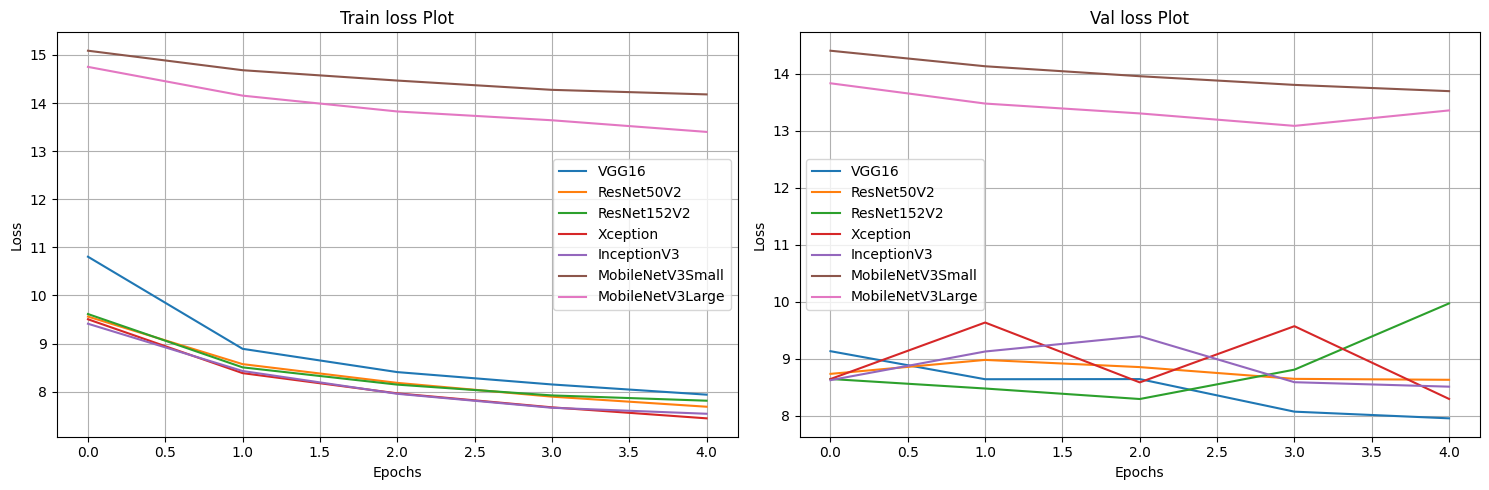

In [ ]:
metric = "loss"
plt.figure(figsize=(15, 5))
for i, sub in enumerate(['Train', 'Val']):

    plt.subplot(1, 2, i+1)
    plt.title(f"{sub} {metric} Plot")

    for name, history in BACKBONE_HISTORIES.items():
        plt.plot(history[metric] if sub=="Train" else history[f"val_{metric}"], label = name)
        plt.xlabel("Epochs")
        plt.ylabel(metric.title())
        plt.legend()
        plt.grid()

plt.tight_layout()
plt.show()

Upon **meticulous examination** of the **age model learning curves**, certain **backbones can be unequivocally excluded from consideration**, specifically those related to **MobileNet**. Their **consistently poor performance** makes them **unsuitable candidates**.

**VGG16** emerges as the **most promising backbone**, exhibiting a **steady decline in both training and validation loss**, converging around **mean absolute error of 8.0**. This coherence indicates **robustness**, distinguishing **VGG16** as a **favorable choice**.

While some other models, such as **Inception and Xception**, yield **lower training losses**, their **considerable gaps** between **training and validation curves** suggest **potential instability**. Considering a **trade-off** between **speed and robustness**, **Inception** stands out as a **commendable alternative**.

Its **smoother growth trajectory** and **relative predictability** make it a **suitable compromise**, especially when compared to the **more erratic performance of Xception**. This nuanced evaluation guides the selection process, ensuring the chosen backbone aligns with desired model characteristics.

In [ ]:
BACKBONE_HISTORIES = {}

for (name, backbone) in backbones:

    print(f"Testing : {name}")

    # Freeze the Model weights
    backbone.trainable = False

    # Creating a base model
    model = keras.Sequential([
        InputLayer((IMAGE_SIZE, IMAGE_SIZE, 3), name = "InputLayer"),
        backbone,
        Dropout(0.2, name = "SlightDropout"),
        Flatten(name = "FlattenEmbeddings"),
        Dense(1, activation="sigmoid", name = "Age")
    ])

    # Train the model for few iterations
    model.compile(
        loss = ["binary_crossentropy"],
        optimizer = "adam",
        metrics = ['accuracy'],
        weighted_metrics=[]
    )

    history = model.fit(
        train_gender_ds,
        validation_data = valid_gender_ds,
        epochs = 5,
        batch_size = BATCH_SIZE
    )

    BACKBONE_HISTORIES[name] = pd.DataFrame(history.history)
    cls()
    print("\n")

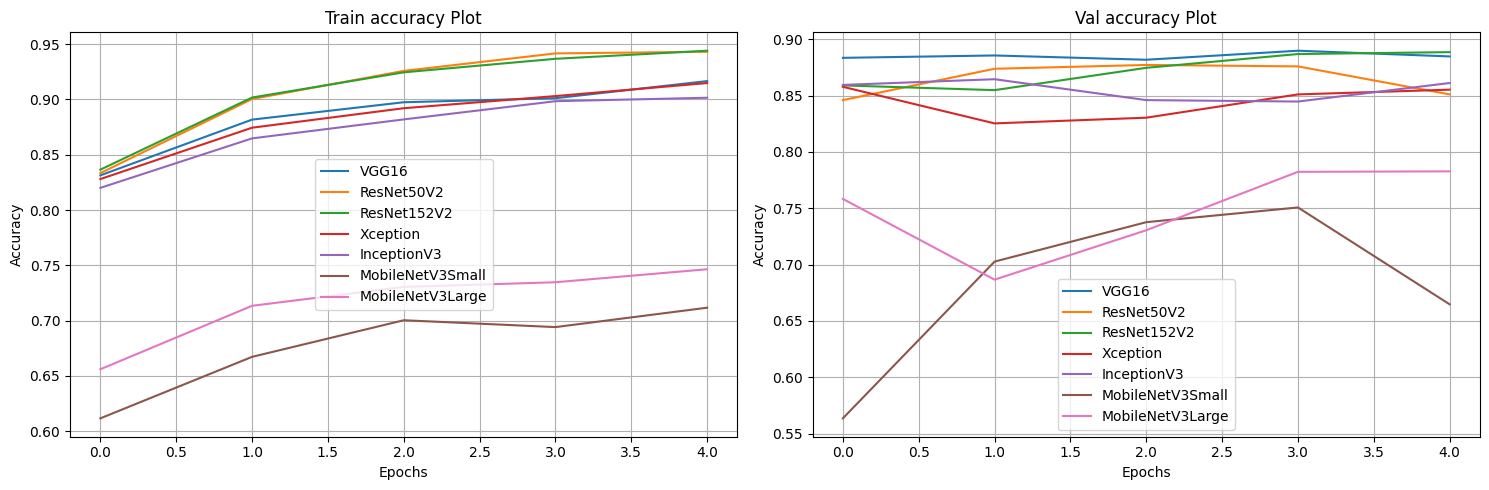

In [ ]:
metric = "accuracy"
plt.figure(figsize=(15, 5))
for i, sub in enumerate(['Train', 'Val']):

    plt.subplot(1, 2, i+1)
    plt.title(f"{sub} {metric} Plot")

    for name, history in BACKBONE_HISTORIES.items():
        plt.plot(history[metric] if sub=="Train" else history[f"val_{metric}"], label = name)
        plt.xlabel("Epochs")
        plt.ylabel(metric.title())
        plt.legend()
        plt.grid()

plt.tight_layout()
plt.show()

In **evaluating models** for **gender prediction** accuracy, a notable **elimination includes the MobileNet models**, which consistently exhibit **inferior performance.**

Delving into **training and validation accuracy curves** unveils a **standout performer**: the **ResNet152V2 model**, represented by the distinctive **green curve**. This model attains the **highest training accuracy and validation accuracy,** positioning it as a **compelling choice**.

However, it's imperative to address the **substantial disparities between training and validation accuracy across all models**. This underscores the need for a **more sophisticated baseline model** during the **final model creation**, incorporating **multiple layers** to better handle these **discrepancies**.

Despite this consideration, **ResNet152V2** maintains its **prominence**, boasting exceptional **training and validation performance**. Notably, **ResNet50V2** demonstrates **commendable proximity** to **ResNet152V2** in **training performance**, albeit **falling short in validation accuracy.**

# **VGG16 Age Network 🤖**

After thorough analysis, the **VGG16 network** emerged as the **optimal backbone** due to its **consistent performance** in **minimizing training and validation losses**. This led to the decision to use **VGG16** as the **shared backbone** for the **Age Model**.

The **Age Model** focuses on **accurate age prediction**, while the **Gender Model** specializes in precise **gender prediction**. Combining both models, we create a **unified network** for simultaneous **age and gender predictions**, leveraging **VGG16's strengths** for **efficient facial attribute detection.**

In [ ]:
# Loading backbone
vgg_16 = VGG16(input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3), include_top = False, weights = "imagenet")

# Freezing the backbone weights
vgg_16.trainable = False

# Creating a Age Network
age_net = Sequential([
    InputLayer((IMAGE_SIZE, IMAGE_SIZE, 3), name="ImageInput"),
    vgg_16,
    Dropout(0.4, name = "SlightDroput"),
    Flatten(name="FlattenEmbeddings"),
    Dense(256, activation="relu", kernel_initializer="he_normal"),
    Dense(1, name="AgeOutput")
], name="AgeNet")

# Compiling Model
age_net.compile(
    loss = "mae",
    optimizer = 'adam',
    weighted_metrics=[]
)

In [ ]:
# Trining the Age Model
age_history = age_net.fit(
    train_age_ds,
    validation_data = valid_age_ds,
    epochs = 20,
    batch_size = BATCH_SIZE,
    callbacks = [
        EarlyStopping(
            patience = 5,
            monitor = "val_loss",
            restore_best_weights = True
        ),

        ModelCheckpoint(
            "Age-VGG16.keras",
            save_best_only=True
        )
    ]
)

Epoch 1/20
667/667 [==============================] - 115s 172ms/step - loss: 9.2629 - val_loss: 7.8959
Epoch 2/20
667/667 [==============================] - 113s 169ms/step - loss: 8.0789 - val_loss: 7.3933
Epoch 3/20
667/667 [==============================] - 113s 169ms/step - loss: 7.6652 - val_loss: 7.2451
Epoch 4/20
667/667 [==============================] - 112s 168ms/step - loss: 7.3321 - val_loss: 7.6312
Epoch 5/20
667/667 [==============================] - 113s 169ms/step - loss: 7.1875 - val_loss: 7.4651
Epoch 6/20
667/667 [==============================] - 114s 170ms/step - loss: 7.0938 - val_loss: 6.9247
Epoch 7/20
667/667 [==============================] - 112s 167ms/step - loss: 6.9751 - val_loss: 7.3712
Epoch 8/20
667/667 [==============================] - 114s 170ms/step - loss: 6.8140 - val_loss: 6.8757
Epoch 9/20
667/667 [==============================] - 113s 170ms/step - loss: 6.7000 - val_loss: 6.8312
Epoch 10/20
667/667 [==============================] - 113s 170m

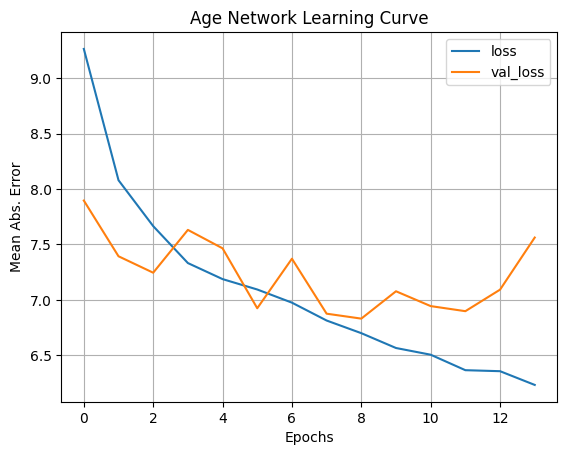

In [ ]:
# Converting history into data frame.
age_his_df = pd.DataFrame(age_history.history)

# Visualization
age_his_df.plot()
plt.title("Age Network Learning Curve")
plt.xlabel("Epochs")
plt.ylabel("Mean Abs. Error")
plt.grid()
plt.show()

The noteworthy achievement lies in surpassing the baseline model's performance in our age prediction model. The model's mean absolute error, which initially hovered around 8, has been successfully reduced to approximately 6.7, indicating substantial progress.

While further improvements could be achieved through parameter tuning and meticulous architectural adjustments, the current loss represents a commendable outcome within the scope of our approach.

Additionally, the incorporation of early stopping proves beneficial in safeguarding against overfitting. Around the 12th and 13th epochs, signs of divergence between training and validation losses emerge, indicative of potential overfitting.

The early stopping mechanism, coupled with model checkpointing, effectively mitigates this concern by reverting to the best-performing model version, which notably occurs around the 7th epoch with the lowest difference values.

# **ResNet152V2 Gender Network 🤖**

In [ ]:
# Initializing the backbone layer
resnet = ResNet152V2(input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3), include_top = False, weights="imagenet")

# Freeze the backbone weights
resnet.trainable = False

# Creating a gender model
gender_net = Sequential([
    InputLayer((IMAGE_SIZE, IMAGE_SIZE, 3), name="ImageInput"),
    resnet,
    Dropout(0.2, name = "SlightDroput"),
    GlobalAveragePooling2D(name="GlobalAvgPooling"),
    Dense(1, activation="sigmoid", name="gender")
], name="GenderNet")

gender_net.compile(
    loss = "binary_crossentropy",
    optimizer = 'adam',
    metrics = ['accuracy'],
    weighted_metrics=[]
)

In [ ]:
# Training the Gender Model
gender_history = gender_net.fit(
    train_gender_ds,
    validation_data = valid_gender_ds,
    epochs = 20,
    batch_size = BATCH_SIZE,
    callbacks = [
        EarlyStopping(
            patience = 5,
            monitor = "val_accuracy",
            restore_best_weights = True
        ),

        ModelCheckpoint(
            "Gender-ResNet152.keras",
            save_best_only=True
        )
    ]
)

Epoch 1/20
667/667 [==============================] - 184s 263ms/step - loss: 0.3888 - accuracy: 0.8246 - val_loss: 0.3304 - val_accuracy: 0.8536
Epoch 2/20
667/667 [==============================] - 171s 256ms/step - loss: 0.3273 - accuracy: 0.8581 - val_loss: 0.3158 - val_accuracy: 0.8667
Epoch 3/20
667/667 [==============================] - 167s 251ms/step - loss: 0.3113 - accuracy: 0.8666 - val_loss: 0.3076 - val_accuracy: 0.8625
Epoch 4/20
667/667 [==============================] - 166s 249ms/step - loss: 0.3031 - accuracy: 0.8694 - val_loss: 0.3048 - val_accuracy: 0.8638
Epoch 5/20
667/667 [==============================] - 172s 257ms/step - loss: 0.2959 - accuracy: 0.8741 - val_loss: 0.3006 - val_accuracy: 0.8680
Epoch 6/20
667/667 [==============================] - 167s 250ms/step - loss: 0.2911 - accuracy: 0.8772 - val_loss: 0.2975 - val_accuracy: 0.8726
Epoch 7/20
667/667 [==============================] - 171s 256ms/step - loss: 0.2880 - accuracy: 0.8775 - val_loss: 0.2929 -

Having completed the training for both the Age Model and Gender Model, it is crucial to assess their learning curves for a comprehensive evaluation.

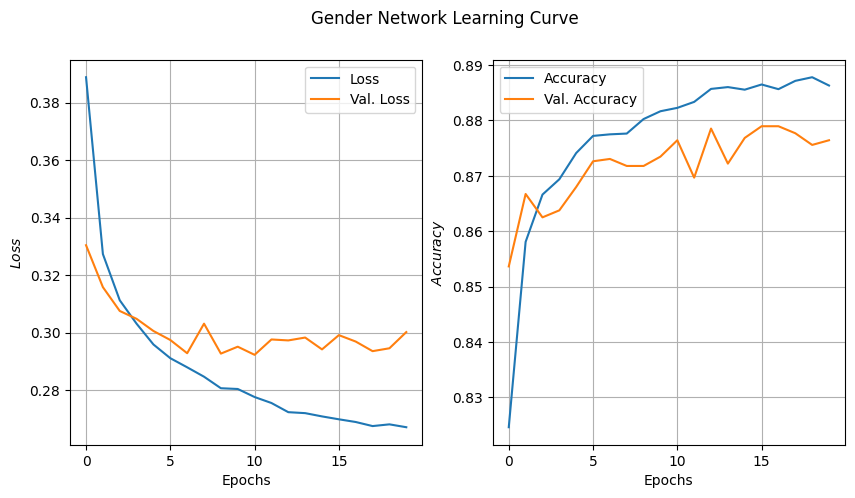

In [ ]:
# Converting history into data frame.
gender_his_df = pd.DataFrame(gender_history.history)

# Visualization
plt.figure(figsize=(10, 5 ))
plt.subplot(1,2,1)
plt.suptitle("Gender Network Learning Curve")
plt.plot(gender_his_df['loss'], label="Loss")
plt.plot(gender_his_df['val_loss'], label="Val. Loss")
plt.xlabel("Epochs")
plt.ylabel("$Loss$")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(gender_his_df['accuracy'], label="Accuracy")
plt.plot(gender_his_df['val_accuracy'], label="Val. Accuracy")
plt.xlabel("Epochs")
plt.ylabel("$Accuracy$")
plt.grid()
plt.legend()

plt.show()

**Significant adjustments** have been made to the structure of the **gender network** to enhance its **robustness**. By **removing flatten layer and Dense layers** and incorporating **GlobalAveragePooling layer**, the **model's overfitting tendencies** have been addressed.

The initial configuration displayed **over 90% training accuracy** but exhibited a **noticeable drop** in **validation accuracy** to **around 85%,** indicating **susceptibility to overfitting**.

The **revised model**, although achieving **slightly lower accuracy**, successfully maintains **a high degree of robustness**. The **loss disparity is minimal**, with **validation loss at approximately 0.30 and training loss at around 0.26**. This **marginal difference** is **mirrored in accuracy**, where training **accuracy stands at 88% and validation accuracy at 87%,** resulting in a mere **1% difference** – a commendable achievement in terms of **model stability.**

# **Model Evaluation**

At this juncture, we have reached a pivotal milestone by completing the core components – **model training and data processing**. The next crucial step involves **evaluating our model's performance** on the **test dataset**. This evaluation provides valuable insights into **how well the model** is **expected to perform in real-world scenarios**. The outcomes of this **testing phase** serve as a **critical benchmark** for assessing **the model's generalization and predictive capabilities on unseen data.**

In [ ]:
# Loading saved models
age_net = tf.keras.models.load_model("/kaggle/input/age-and-gender-prediction-vgg16-resnet152v2/Weights/Age-VGG16.keras", compile=True)
gender_net = tf.keras.models.load_model("/kaggle/input/age-and-gender-prediction-vgg16-resnet152v2/Weights/Gender-ResNet152.keras", compile=True)

In [ ]:
# Evaluating test performance
age_net.evaluate(test_age_ds)
gender_net.evaluate(test_gender_ds)

75/75 [==============================] - 17s 221ms/step - loss: 0.2609 - accuracy: 0.8887


[0.2609206438064575, 0.8886545896530151]

The conclusive evaluation of our final model on the test data reveals a significant enhancement in performance compared to the preliminary versions, where we focused solely on backbone comparisons. This demonstrates our successful efforts in refining and optimizing the model, leading to a substantial improvement in overall performance. The iterative process of fine-tuning and parameter adjustments has evidently paid off, showcasing the model's increased efficacy and reliability in predicting age and gender on previously unseen data.

# **Model Predictions**

Visualizing the model's performance against the test samples adds an engaging and insightful dimension to our evaluation. Through graphical representation, we can gain a more intuitive understanding of how the model behaves across different instances. This visual exploration allows us to identify patterns, trends, or potential areas of improvement that might not be immediately apparent in the numerical metrics alone. Let's delve into the visual representation to uncover the nuances of our model's performance on the test data.

In [ ]:
plt.figure(figsize=(15, 10))
for images, ages, genders in test_ds.batch(BATCH_SIZE).take(1):

    # Predictions
    pred_ages = tf.round(age_net.predict(image, verbose=0), 2)
    pred_genders = tf.round(gender_net.predict(image, verbose=0))

    for index in range(len(images)):

        # Image Processing
        image = tf.io.read_file(dir_path + images[index])
        image = tf.io.decode_jpeg(image)
        image = tf.cast(image, tf.float32)
        image = image/255.
        image = tf.image.resize(image, [224,224])
        image = tf.reshape(image, [-1,224,224,3])

        # Visualization
        plt.subplot(4, 8, index + 1)
        plt.imshow(image[0])
        plt.title(f"Age: {int(pred_ages[index])}\nGender: {gender_mapping[int(pred_ages[index])]}")
        plt.axis("off")

plt.tight_layout()
plt.show()